<!--BOOK_INFORMATION-->

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

# In Depth: Naive Bayes Classification

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: 

If we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that you have the following data:

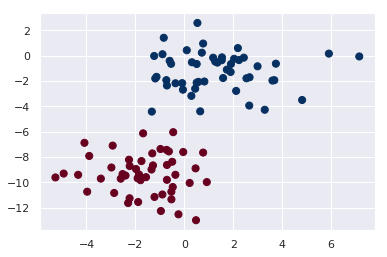

In [26]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions.
This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:


[(-15, 5), (-8, 8)]

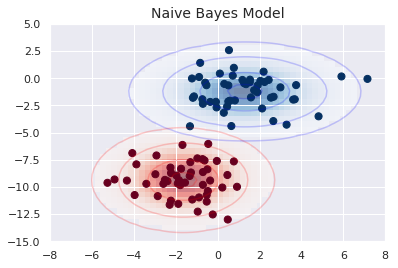

In [27]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.01)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9], #probabilities for which to draw ellipses
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:

In [28]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [29]:
rng = np.random.RandomState(0)
Xnew = [-8, -15] + [16, 20] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

[(-15, 5), (-8, 8)]

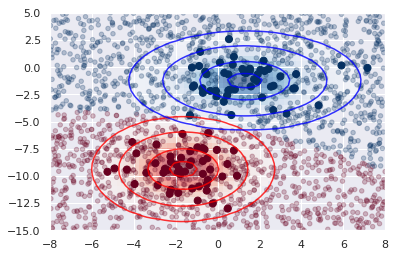

In [30]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
ax.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.25)

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    #notice we are now using mean and std found by GaussianNB
    mu = model.theta_[label,:]
    std = np.sqrt(model.sigma_[label,:])
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.01)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9], #probabilities for which to draw ellipses
               colors=color, alpha=0.8)

ax.set(xlim=xlim, ylim=ylim)

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

A nice feature of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the ``predict_proba`` method:

In [31]:
yprob = model.predict_proba(Xnew)
print(yprob[-15:].round(2))

[[0.   1.  ]
 [0.24 0.76]
 [0.   1.  ]
 [0.   1.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.89 0.11]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.5  0.5 ]]


The columns give the posterior probabilities of the first and second label, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.

The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
Here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [32]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [33]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [34]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers.
For this we will use the TF-IDF vectorizer, and create a pipeline that attaches it to a multinomial naive Bayes classifier:

## Text Features

A common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example:

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform([train.data[5],train.data[6]])
X
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

10  15  1919  20054  2493  ac  ago  airways  also  america  ...   usa  use  \
0   1   1     1      1     1   0    1        1     1        1  ...     1    1   
1   0   0     0      0     0   1    0        0     0        0  ...     0    0   

   washington  waste  who  will  william  with  years  your  
0           1      0    1     0        0     1      1     1  
1           0      1    0     2        1     0      0     0  

[2 rows x 103 columns]

There are some issues with this approach, however: The raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*) which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform([train.data[5],train.data[6]])
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

10        15      1919     20054      2493        ac       ago  \
0  0.071916  0.071916  0.071916  0.071916  0.071916  0.000000  0.071916   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.201902  0.000000   

    airways      also   america    ...          usa       use  washington  \
0  0.071916  0.071916  0.071916    ...     0.071916  0.071916    0.071916   
1  0.000000  0.000000  0.000000    ...     0.000000  0.000000    0.000000   

      waste       who      will   william      with     years      your  
0  0.000000  0.071916  0.000000  0.000000  0.071916  0.071916  0.071916  
1  0.201902  0.000000  0.403804  0.201902  0.000000  0.000000  0.000000  

[2 rows x 103 columns]

## Feature Pipelines

It can quickly become tedious to do transformations like this by hand, especially if you wish to string together multiple steps.

To streamline this into a type of processing pipeline, Scikit-Learn provides a ``Pipeline`` object, which can be used as follows:

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data.
The pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [42]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

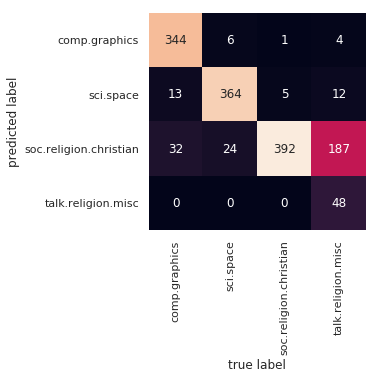

In [43]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [44]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [45]:
predict_category('sending a payload to the ISS')

'sci.space'

In [46]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [47]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## When to Use Naive Bayes

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as more complicated models.
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: You have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: As the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.
We will return to this topic in L08, "Breaking the Curse of Dimensionality".

## Assignment to go into journal J2

Apply a Naive Bayes classifier to the MNIST dataset.

Pick the version of Naive Bayes you think is best suited, and motivate your choice in the journal.

Specify your results using metrics of your own choice (again motivate in the journal), and perspectivise to previous results on the same dataset, e.g. are they comparable, better or worse, and make some suggestions why?

In [4]:
import numpy as np
import tensorflow as tf
import six as sx
from datetime import datetime
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn

# Fetch data from MNIST
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()

# Shuffle the data
shuffle_index = np.random.permutation(60000)
Xtrain, Ytrain = Xtrain[shuffle_index], Ytrain[shuffle_index]

# reshape our date for train
if Xtrain.ndim==3 and Xtest.ndim==3:
    Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1]*Xtrain.shape[2])
    Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1]*Xtest.shape[2]) 
    
# Creating Gaussian Naive Bayes classifier
class CustomGaussianNB(object):
    # Fitting
    def fit(self, X, Y):
        # Declaring dictionary to hold mean and variance values
        self.gaussians = dict()
        # Declaring dictionary to hold prior value
        self.priors = dict()
        # Value to smooth out variance
        smoothing = 1e-2
        #Creating set Y values as labels
        labels = set(Y)
        
        for digit in labels:
            current_x = X[Y == digit]
            self.gaussians[digit] = {
                # Storing mean and variance values
                'mean': current_x.mean(axis=0),
                'var': current_x.var(axis=0) + smoothing,
            }
            # Storing prior value
            self.priors[digit] = float(len(Y[Y == digit])) / len(Y)
    
    # Accurracy score
    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)
    
    # Predictions
    def predict(self, X):
        N, D = X.shape
        K = len(self.gaussians)
        P = np.zeros((N, K))
        # Looping through gaussion dictionary and using logpdf to predict
        for c, g in sx.iteritems(self.gaussians):
            mean, var = g['mean'], g['var']
            P[:,c] = mvn.logpdf(X, mean=mean, cov=var) + np.log(self.priors[c])
        return np.argmax(P, axis=1)

## Comparison with other Naive Bayes versions

In [5]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

model1 = CustomGaussianNB()
model1.fit(Xtrain, Ytrain)
TrainScore_model1 = model1.score(Xtrain,Ytrain)*100
TestScore_model1 = model1.score(Xtest,Ytest)*100

model2 = GaussianNB()
model2.fit(Xtrain, Ytrain)
TrainScore_model2 = model2.score(Xtrain,Ytrain)*100
TestScore_model2 = model2.score(Xtest,Ytest)*100

model3 = MultinomialNB()
model3.fit(Xtrain, Ytrain)
TrainScore_model3 = model3.score(Xtrain,Ytrain)*100
TestScore_model3 = model3.score(Xtest,Ytest)*100

model4 = ComplementNB()
model4.fit(Xtrain, Ytrain)
TrainScore_model4 = model4.score(Xtrain,Ytrain)*100
TestScore_model4 = model4.score(Xtest,Ytest)*100

model5 = BernoulliNB()
model5.fit(Xtrain, Ytrain)
TrainScore_model5 = model5.score(Xtrain,Ytrain)*100
TestScore_model5 = model5.score(Xtest,Ytest)*100

print("CustomGaussianNB: Train accuracy score:", TrainScore_model1, "%")
print("CustomGaussianNB: Test accuracy score:", TestScore_model1, "%")
print("GaussianNB: Train accuracy score:", TrainScore_model2, "%")
print("GaussianNB: Test accuracy score:", TestScore_model2, "%")
print("MultinomialNB: Train accuracy score:", TrainScore_model3, "%")
print("MultinomialNB: Test accuracy score:", TestScore_model3, "%")
print("ComplementNB: Train accuracy score:", TrainScore_model4, "%")
print("ComplementNB: Test accuracy score:", TestScore_model4, "%")
print("BernoulliNB: Train accuracy score:", TrainScore_model5, "%")
print("BernoulliNB: Test accuracy score:", TestScore_model5, "%")


CustomGaussianNB: Train accuracy score: 61.46 %
CustomGaussianNB: Test accuracy score: 61.29 %
GaussianNB: Train accuracy score: 56.489999999999995 %
GaussianNB: Test accuracy score: 55.58 %
MultinomialNB: Train accuracy score: 82.52833333333334 %
MultinomialNB: Test accuracy score: 83.65 %
ComplementNB: Train accuracy score: 71.53666666666668 %
ComplementNB: Test accuracy score: 72.85000000000001 %
BernoulliNB: Train accuracy score: 83.125 %
BernoulliNB: Test accuracy score: 84.13000000000001 %


# Discussion

We decided to implement the Gaussian Naive Bayes classifier simply because of the lower complexity, but this isn't the best choice for the MNIST dataset. Because of the assumption of the normal distribution, Gaussian Naive Bayes is used in cases when all our features are continuous. For example in Iris dataset features are sepal width, petal width, sepal length, petal length. So its features can have different values in data set as width and length can vary. We can’t represent features in terms of their occurrences. This means data is continuous. Therefore this isn't the right choice for the MNIST dataset and this is why we have a lower accuracy score.

The Bernoulli Naive Bayes classifier assumes that all our features are binary such that they take only two values. For example, if we would only care about the presence or absence of a particular word in a document. This might be a better choice for the MNIST dataset hence the higher accuracy score.

Multinomial Naive Bayes is used when we have discrete data. We have seen it used on movie rating data (e.g. ranging 1 and 5 as each rating will have certain frequency to represent). This also might be a better choice for the MNIST dataset.

Complement Naive Bayes is a classifier that tends to work better than the stadard Naive Bayes classes in the training set are imbalanced. In short, it estimates feature probabilities for each class y based on the complement of y, i.e. on all other classes' samples, instead of on the training samples of class y itself.

## Which classifier is the most accurate?
In order to find the best classifier we should start by analyzing the data and seeing if there is a specific property that may give us a hint to use a specific model. If there is no such property or the data has more than three variables that make it impossible to be visualized, then we can only test a variety of models and compare their precision alongside with sensitivity and confidence interval in order to find the best model.

A simple model like K-Nearest Neighbor (K-NN) may offer a better accuracy than a complex model like Support Vector Machines (SVM) and various Naive Bayes classifiers, depending on data. So there is no such “most accurate classifier for MNIST”. Based on the Naive Bayes classifier models tested in this assignment we see that the best choice in this case would be the Bernoulli Naive Bayes.

## Optional extension

Just like we extracted features from the texts above, it is common to extract features from images instead of using the raw pixel values.

Extract some features from MNIST images, and train/test your Naive Bayes on that.

Compare with results from raw pixels. Are your features better? Slower or faster?

Hints: You can for example use HOG (skimage.feature.hog) to extract image features. You probably need to try different parameters for the HOG transform.

It can be helpful to create a pipeline like we did above for the text features; for this you will need to create a 'transform' function that applies HOG. (You can look up how to make transform functions).
When creating transform functions for a pipeline you need to think about output from one transform matching input to the next transform..